In [1]:
import pandas as pd
import numpy as np

Loading the data, from here is needed the class vector

In [43]:
# open file in read mode and read data 
filename = '../processed_data/mfccs_big_and_small.npy'
with open(filename, 'rb') as f:
    Xb = np.load(f)
    yb = np.load(f)
    Xs = np.load(f)
    ys = np.load(f)
    Xbl = np.load(f)
    ybl = np.load(f)
    Xsl = np.load(f)
    ysl = np.load(f)
# Check that we've recovered the right data
print(f'Xb:{Xb.shape}, yb:{yb.shape}')
print(f'Xs:{Xs.shape}, ys:{ys.shape}')
print(f'Xb:{Xbl.shape}, yb:{ybl.shape}')
print(f'Xs:{Xsl.shape}, ys:{ysl.shape}')

Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)
Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)


In [44]:
filename = '../processed_data/more_features.npy'
# open file in write mode and write data
with open('processed_data/more_features.npy'
          , 'rb') as f:
    rms_energy = np.load(f,allow_pickle=True)  # este error aparece como propio de OS
    zero_cross = np.load(f,allow_pickle=True)
    spectral_centroid = np.load(f,allow_pickle=True)
print(f'rms_energy:{rms_energy.shape}')
print(f'zero_cross:{zero_cross.shape}')
print(f'spectral_centroid:{spectral_centroid.shape}')

rms_energy:(1440, 1, 563)
zero_cross:(1440, 1, 282)
spectral_centroid:(1440, 282)


In [45]:
spectral_len = []
for i in range(1440):
    #print(spectral_centroid[i].shape)
    spectral_len.append(spectral_centroid[i].shape[0])

The spectral centroids don't have the same lenght, the minimum length was established to truncate the bigger vectors. 

In [48]:
X = np.zeros((1440,1127))
for i in range(1440):
    X[i,:] = np.hstack((rms_energy[i,:,:],zero_cross[i,:,:],np.reshape(spectral_centroid[i],(1,282))))

In [49]:
X.shape

(1440, 1127)

### Training the new models. 

Now the ensemble methods are trained with the time and frequency features extracted. 

In [50]:
from eval_classifiers import EvalClassifiers
from eval_classifiers import EvalBestModel

In [51]:
time_freq_ensembles = EvalClassifiers("time_freq_ensembles", X, ys, n_splits=10)

In [52]:
time_freq_ensembles 

,Random Forest,AdaBoost,DecisionTree
0,0.455263,0.363816,0.242434
0,0.437829,0.352303,0.376645
0,0.427961,0.347697,0.361842
0,0.461513,0.257566,0.233882
0,0.423026,0.242763,0.259539
0,0.514145,0.319737,0.318750
0,0.368494,0.279167,0.344152
0,0.469189,0.279751,0.317836
0,0.442836,0.335892,0.274817
0,0.471418,0.297661,0.320541


In [53]:
time_freq_ensembles.to_csv('results/time_freq_ensembles.csv',index=False)

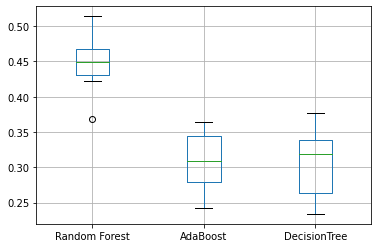

In [54]:
boxplot = time_freq_ensembles.boxplot(column=["Random Forest", "AdaBoost", "DecisionTree"])

### Intentando 90-10 

In [55]:
from eval_classifiers import EvalClassifiers_9010

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, ys, test_size=0.10, random_state=42)

In [58]:
b_9010 = EvalClassifiers_9010('big_9010', X_train_b, y_train_b, X_test_b, y_test_b)

Random Forest
              precision    recall  f1-score   support

           1       0.36      0.44      0.40         9
           2       0.69      0.80      0.74        25
           3       0.38      0.26      0.31        19
           4       0.11      0.08      0.10        12
           5       0.52      0.67      0.59        18
           6       0.42      0.28      0.33        18
           7       0.65      0.72      0.68        18
           8       0.56      0.60      0.58        25

    accuracy                           0.52       144
   macro avg       0.46      0.48      0.47       144
weighted avg       0.50      0.52      0.50       144

 
AdaBoost
              precision    recall  f1-score   support

           1       0.22      0.44      0.30         9
           2       0.62      0.40      0.49        25
           3       0.23      0.16      0.19        19
           4       0.16      0.25      0.19        12
           5       0.27      0.72      0.39        18

**Conclusion**: The Random Forest model is the best choice in this kind of problem but until now the overall performance is low.
Neutral and Fearful are the two classes with the lowest accuracy metrics for the random forest model. 

Changing sample rate from 22050 to 48000 changes the performance in the random forest model (but the improve is not significative). 

### Using an expert set of parameters: a big random forest model.

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
final_model = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [62]:
# Process the data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [63]:
final_model_results = EvalBestModel(final_model ,X_scale,ys)

In [64]:
final_model_results

,Best Model
0,0.438158
0,0.456579
0,0.416447
0,0.468750
0,0.488487
0,0.502632
0,0.432310
0,0.445870
0,0.429349
0,0.430154


### Merging: time-frequency and independent time or frequency features

Probably there exists no independence between this varaibles, but it was created som non linear relations between them (spectrum and spectral centroids for example) 

In [66]:
X_total = np.zeros((1440,1167))
for i in range(1440):
    X_total[i,:] = np.hstack((rms_energy[i,:,:],zero_cross[i,:,:],np.reshape(spectral_centroid[i],(1,282)), np.reshape(Xb[i,:],(1,40))))

In [67]:
time_freq_ensembles_plus_spec = EvalClassifiers("time_freq_ensembles_plus_spec", X_total, ys, n_splits=10)

In [68]:
time_freq_ensembles_plus_spec 

,Random Forest,AdaBoost,DecisionTree
0,0.444079,0.330263,0.415461
0,0.404934,0.248684,0.325987
0,0.460855,0.308224,0.267105
0,0.437171,0.257895,0.364474
0,0.455263,0.268092,0.313487
0,0.521382,0.338816,0.332237
0,0.484613,0.313121,0.325073
0,0.436550,0.279276,0.352851
0,0.425804,0.274817,0.319225
0,0.461988,0.199635,0.273428


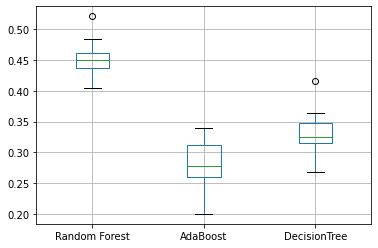

In [69]:
boxplot = time_freq_ensembles_plus_spec.boxplot(column=["Random Forest", "AdaBoost", "DecisionTree"])

Merging time frequency features with spectrum by using a bigger sample rate didn't improve the results!

### Observing the variation due to ```StandardScaler```

In [70]:
# Process the data
scaler = StandardScaler()
X_total_scale = scaler.fit_transform(X_total)

In [73]:
time_freq_ensembles_plus_spec_stand = EvalClassifiers("time_freq_ensembles_plus_spec", X_total_scale , ys, n_splits=10)

In [74]:
time_freq_ensembles_plus_spec_stand 

,Random Forest,AdaBoost,DecisionTree
0,0.463816,0.330263,0.364145
0,0.520395,0.248684,0.313487
0,0.357237,0.308224,0.292105
0,0.423355,0.257895,0.352303
0,0.506579,0.268092,0.377303
0,0.494408,0.338816,0.344737
0,0.432639,0.313121,0.350731
0,0.437865,0.279276,0.327668
0,0.411404,0.274817,0.308114
0,0.469956,0.199635,0.267251


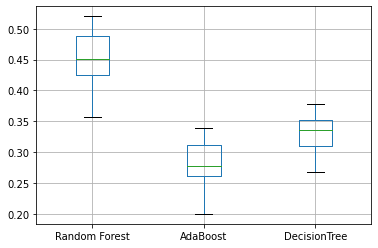

In [75]:
boxplot = time_freq_ensembles_plus_spec_stand .boxplot(column=["Random Forest", "AdaBoost", "DecisionTree"])

### Testing the Random Forest with ```n_estimators``` with a large value. 

In [45]:
final_model_X_new = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [46]:
merged_model = EvalBestModel(final_model_X_new ,X_total_scale ,ys)

In [47]:
merged_model

,Best Model
0,0.431579
0,0.501974
0,0.448684
0,0.481908
0,0.494737
0,0.508882
0,0.445468
0,0.433370
0,0.456725
0,0.463450


### Final Plot

In [52]:
merging_features_non_spectral = final_model_results["Best Model"]
merging_features_non_spectral_and_spectrum  = merged_model["Best Model"]
time_freq_ensembles_plus_spec_stand_1 = time_freq_ensembles_plus_spec_stand["Random Forest"]
model1 = np.reshape(np.asarray(merging_features_non_spectral),(10,1))
model2 = np.reshape(np.asarray(merging_features_non_spectral_and_spectrum ),(10,1))
model3 = np.reshape(np.asarray(time_freq_ensembles_plus_spec_stand_1 ),(10,1))
B = np.hstack((model1 ,model2,model3))

In [53]:
import matplotlib.pyplot as plt

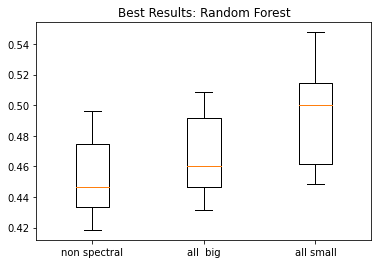

In [57]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best Results: Random Forest')
ax7.boxplot(B)
plt.xticks([1,2,3], ['non spectral','all  big','all small'])
plt.show()

# Using data augmentation and all features!

In [2]:
filename = '../processed_data/ALL40_48.npy'
with open(filename, 'rb') as f:
    ALL40_48 = np.load(f)

In [3]:
features= ALL40_48

In [4]:
filename = '../processed_data/ZE_48.npy'
# open file in write mode and write data
with open(filename, 'rb') as f:
    Z = np.load(f)
    E = np.load(f)
    Y = np.load(f)

In [6]:
from sklearn.model_selection import train_test_split

In [9]:
from eval_classifiers import EvalClassifiers
from eval_classifiers import EvalBestModel

In [7]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(features, Y, test_size=0.10, random_state=42)

In [10]:
all_features_augmented = EvalClassifiers("all_features_aug_40_48",X_train_b , y_train_b, n_splits=10)

In [11]:
all_features_augmented

,Random Forest,AdaBoost,DecisionTree
0,0.978351,0.361735,0.812741
0,0.976565,0.329646,0.798398
0,0.970928,0.354766,0.774250
0,0.982103,0.368133,0.791237
0,0.971336,0.338475,0.801776
0,0.977882,0.366614,0.801814
0,0.983479,0.329645,0.793335
0,0.985505,0.386202,0.823527
0,0.985425,0.360587,0.803326
0,0.985371,0.328522,0.816038


In [12]:
all_features_augmented.describe()

,Random Forest,AdaBoost,DecisionTree
count,10.000000,10.000000,10.000000
mean,0.979694,0.352432,0.801644
std,0.005583,0.019865,0.013946
min,0.970928,0.328522,0.774250
25%,0.976894,0.331853,0.794600
50%,0.980227,0.357676,0.801795
75%,0.984898,0.365394,0.810387
max,0.985505,0.386202,0.823527


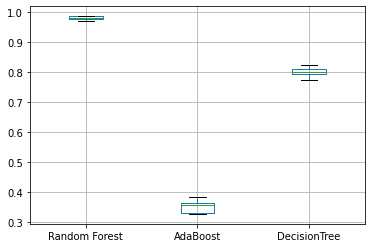

In [13]:
boxplot = all_features_augmented.boxplot(column=["Random Forest", "AdaBoost", "DecisionTree"])

In [14]:
filename = '../processed_data/ALL40_22.npy'
with open(filename, 'rb') as f:
    ALL40_22 = np.load(f)

In [15]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(ALL40_22, Y, test_size=0.10, random_state=42)

In [16]:
all_features_augmented_22 = EvalClassifiers("all_features_aug_40_22",X_train_b , y_train_b, n_splits=10)

In [17]:
all_features_augmented_22

,Random Forest,AdaBoost,DecisionTree
0,0.837852,0.296773,0.723467
0,0.819143,0.329623,0.690680
0,0.830141,0.351188,0.725685
0,0.823637,0.324296,0.719363
0,0.843297,0.350698,0.742687
0,0.851096,0.340459,0.745769
0,0.838683,0.310499,0.764873
0,0.844608,0.342124,0.718479
0,0.838917,0.337223,0.691750
0,0.851902,0.332033,0.746011


In [18]:
all_features_augmented_22.describe()

,Random Forest,AdaBoost,DecisionTree
count,10.000000,10.000000,10.000000
mean,0.837928,0.331491,0.726876
std,0.010860,0.017272,0.023807
min,0.819143,0.296773,0.690680
25%,0.832069,0.325628,0.718700
50%,0.838800,0.334628,0.724576
75%,0.844280,0.341708,0.744998
max,0.851902,0.351188,0.764873


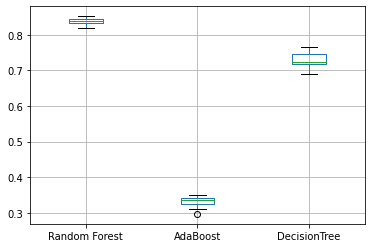

In [19]:
boxplot = all_features_augmented_22.boxplot(column=["Random Forest", "AdaBoost", "DecisionTree"])

Conclusion: utilizar más caracteristicas y mayor frecuencia de muestreo permite obtener mejores resultados!